In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "200X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 2


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_200X-BREAKHIS-Dataset-60-10-30-VGGINet/2'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/200X/2'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1087 files belonging to 2 classes.


Found 181 files belonging to 2 classes.


Found 545 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3296 - accuracy: 0.5156

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 4s - loss: 3.0260 - accuracy: 0.6562

3/9 [=========>....................] - ETA: 9s - loss: 4.1605 - accuracy: 0.6875

4/9 [============>.................] - ETA: 7s - loss: 4.6871 - accuracy: 0.6855

5/9 [===============>..............] - ETA: 6s - loss: 4.8145 - accuracy: 0.6922

6/9 [===================>..........] - ETA: 4s - loss: 4.5430 - accuracy: 0.7161

7/9 [======================>.......] - ETA: 2s - loss: 4.2778 - accuracy: 0.7344

8/9 [=========================>....] - ETA: 1s - loss: 4.0135 - accuracy: 0.7529

9/9 [==============================] - ETA: 0s - loss: 4.0505 - accuracy: 0.7571

9/9 [==============================] - 25s 3s/step - loss: 4.0505 - accuracy: 0.7571 - val_loss: 8.6631 - val_accuracy: 0.8398


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 2.1875 - accuracy: 0.8359

2/9 [=====>........................] - ETA: 3s - loss: 2.6360 - accuracy: 0.8164

3/9 [=========>....................] - ETA: 7s - loss: 2.3204 - accuracy: 0.8438

4/9 [============>.................] - ETA: 6s - loss: 2.1437 - accuracy: 0.8574

5/9 [===============>..............] - ETA: 6s - loss: 1.9331 - accuracy: 0.8672

6/9 [===================>..........] - ETA: 4s - loss: 1.8895 - accuracy: 0.8672

7/9 [======================>.......] - ETA: 3s - loss: 2.1011 - accuracy: 0.8650

8/9 [=========================>....] - ETA: 1s - loss: 2.0724 - accuracy: 0.8672

9/9 [==============================] - ETA: 0s - loss: 2.0354 - accuracy: 0.8694

9/9 [==============================] - 15s 2s/step - loss: 2.0354 - accuracy: 0.8694 - val_loss: 18.6798 - val_accuracy: 0.7514


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9854 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 12s - loss: 0.8599 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 9s - loss: 1.0988 - accuracy: 0.9010 

4/9 [============>.................] - ETA: 9s - loss: 1.1748 - accuracy: 0.8965

5/9 [===============>..............] - ETA: 6s - loss: 1.2935 - accuracy: 0.8938

6/9 [===================>..........] - ETA: 4s - loss: 1.3105 - accuracy: 0.8906

7/9 [======================>.......] - ETA: 3s - loss: 1.3332 - accuracy: 0.8850

8/9 [=========================>....] - ETA: 1s - loss: 1.2935 - accuracy: 0.8828

9/9 [==============================] - ETA: 0s - loss: 1.2834 - accuracy: 0.8813

9/9 [==============================] - 15s 2s/step - loss: 1.2834 - accuracy: 0.8813 - val_loss: 2.1716 - val_accuracy: 0.8950


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9683 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 13s - loss: 0.9013 - accuracy: 0.8906

3/9 [=========>....................] - ETA: 9s - loss: 1.2200 - accuracy: 0.8880 

4/9 [============>.................] - ETA: 9s - loss: 1.1740 - accuracy: 0.8887

5/9 [===============>..............] - ETA: 7s - loss: 1.3038 - accuracy: 0.8906

6/9 [===================>..........] - ETA: 5s - loss: 1.2942 - accuracy: 0.8919

7/9 [======================>.......] - ETA: 3s - loss: 1.2826 - accuracy: 0.8917

8/9 [=========================>....] - ETA: 1s - loss: 1.2414 - accuracy: 0.8955

9/9 [==============================] - ETA: 0s - loss: 1.2126 - accuracy: 0.8942

9/9 [==============================] - 16s 2s/step - loss: 1.2126 - accuracy: 0.8942 - val_loss: 4.6964 - val_accuracy: 0.8343


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4347 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.7316 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 15s - loss: 0.7618 - accuracy: 0.9167

4/9 [============>.................] - ETA: 10s - loss: 0.7724 - accuracy: 0.9121

5/9 [===============>..............] - ETA: 7s - loss: 0.8538 - accuracy: 0.9141 

6/9 [===================>..........] - ETA: 5s - loss: 0.9259 - accuracy: 0.9062

7/9 [======================>.......] - ETA: 3s - loss: 0.9649 - accuracy: 0.9040

8/9 [=========================>....] - ETA: 1s - loss: 0.9710 - accuracy: 0.9033

9/9 [==============================] - ETA: 0s - loss: 0.9512 - accuracy: 0.9052

9/9 [==============================] - 16s 2s/step - loss: 0.9512 - accuracy: 0.9052 - val_loss: 1.7182 - val_accuracy: 0.9227


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7786 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 3s - loss: 0.6803 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 1.1203 - accuracy: 0.9167

4/9 [============>.................] - ETA: 10s - loss: 1.2227 - accuracy: 0.9102

5/9 [===============>..............] - ETA: 7s - loss: 1.2357 - accuracy: 0.9000 

6/9 [===================>..........] - ETA: 5s - loss: 1.3137 - accuracy: 0.8971

7/9 [======================>.......] - ETA: 3s - loss: 1.1988 - accuracy: 0.9029

8/9 [=========================>....] - ETA: 1s - loss: 1.2510 - accuracy: 0.8975

9/9 [==============================] - ETA: 0s - loss: 1.2979 - accuracy: 0.8951

9/9 [==============================] - 16s 2s/step - loss: 1.2979 - accuracy: 0.8951 - val_loss: 2.5383 - val_accuracy: 0.8674


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2315 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 13s - loss: 1.0625 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 9s - loss: 0.9203 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 7s - loss: 0.7731 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 8s - loss: 0.8521 - accuracy: 0.9250

6/9 [===================>..........] - ETA: 5s - loss: 0.9384 - accuracy: 0.9167

7/9 [======================>.......] - ETA: 3s - loss: 0.9793 - accuracy: 0.9107

8/9 [=========================>....] - ETA: 1s - loss: 0.9257 - accuracy: 0.9131

9/9 [==============================] - ETA: 0s - loss: 0.9603 - accuracy: 0.9080

9/9 [==============================] - 17s 2s/step - loss: 0.9603 - accuracy: 0.9080 - val_loss: 1.3410 - val_accuracy: 0.9227


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6738 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 12s - loss: 0.7507 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 9s - loss: 0.7548 - accuracy: 0.9219 

4/9 [============>.................] - ETA: 9s - loss: 0.8315 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 6s - loss: 0.8140 - accuracy: 0.9172

6/9 [===================>..........] - ETA: 4s - loss: 0.9069 - accuracy: 0.9115

7/9 [======================>.......] - ETA: 3s - loss: 0.8726 - accuracy: 0.9129

8/9 [=========================>....] - ETA: 1s - loss: 0.8070 - accuracy: 0.9160

9/9 [==============================] - ETA: 0s - loss: 0.7888 - accuracy: 0.9172

9/9 [==============================] - 15s 2s/step - loss: 0.7888 - accuracy: 0.9172 - val_loss: 1.1239 - val_accuracy: 0.9171


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 1.6342 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 0.9076 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.9462 - accuracy: 0.9271 

4/9 [============>.................] - ETA: 9s - loss: 0.8709 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 0.9353 - accuracy: 0.9203

6/9 [===================>..........] - ETA: 5s - loss: 0.8632 - accuracy: 0.9245

7/9 [======================>.......] - ETA: 3s - loss: 0.8381 - accuracy: 0.9230

8/9 [=========================>....] - ETA: 1s - loss: 0.8280 - accuracy: 0.9209

9/9 [==============================] - ETA: 0s - loss: 0.8639 - accuracy: 0.9181

9/9 [==============================] - 16s 2s/step - loss: 0.8639 - accuracy: 0.9181 - val_loss: 0.5376 - val_accuracy: 0.9503


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0240 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 13s - loss: 0.7046 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 9s - loss: 0.6275 - accuracy: 0.9219 

4/9 [============>.................] - ETA: 10s - loss: 0.6881 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 7s - loss: 0.6965 - accuracy: 0.9234 

6/9 [===================>..........] - ETA: 5s - loss: 0.6405 - accuracy: 0.9284

7/9 [======================>.......] - ETA: 3s - loss: 0.6543 - accuracy: 0.9241

8/9 [=========================>....] - ETA: 1s - loss: 0.6518 - accuracy: 0.9258

9/9 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.9227

9/9 [==============================] - 16s 2s/step - loss: 0.7108 - accuracy: 0.9227 - val_loss: 1.3105 - val_accuracy: 0.8950


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3057 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.4693 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.4624 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.4810 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.5429 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 4s - loss: 0.4721 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.4914 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.4929 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.9503

9/9 [==============================] - 15s 2s/step - loss: 0.5004 - accuracy: 0.9503 - val_loss: 1.8105 - val_accuracy: 0.8729


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1431 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 15s - loss: 0.9192 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.8364 - accuracy: 0.9401

4/9 [============>.................] - ETA: 10s - loss: 0.8381 - accuracy: 0.9395

5/9 [===============>..............] - ETA: 7s - loss: 0.7168 - accuracy: 0.9438 

6/9 [===================>..........] - ETA: 5s - loss: 0.8080 - accuracy: 0.9284

7/9 [======================>.......] - ETA: 3s - loss: 0.8340 - accuracy: 0.9263

8/9 [=========================>....] - ETA: 1s - loss: 0.8246 - accuracy: 0.9277

9/9 [==============================] - ETA: 0s - loss: 0.8086 - accuracy: 0.9292

9/9 [==============================] - 16s 2s/step - loss: 0.8086 - accuracy: 0.9292 - val_loss: 0.9881 - val_accuracy: 0.9282


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5559 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.9075 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 16s - loss: 0.9466 - accuracy: 0.9427

4/9 [============>.................] - ETA: 11s - loss: 1.1048 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 8s - loss: 1.0399 - accuracy: 0.9344 

6/9 [===================>..........] - ETA: 5s - loss: 0.9933 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.9283 - accuracy: 0.9375

8/9 [=========================>....] - ETA: 1s - loss: 0.8673 - accuracy: 0.9375

9/9 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.9384

9/9 [==============================] - 17s 2s/step - loss: 0.8682 - accuracy: 0.9384 - val_loss: 1.0672 - val_accuracy: 0.9227


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6183 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.8524 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 10s - loss: 0.7886 - accuracy: 0.9167

4/9 [============>.................] - ETA: 9s - loss: 0.7687 - accuracy: 0.9219 

5/9 [===============>..............] - ETA: 7s - loss: 0.6651 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 5s - loss: 0.9337 - accuracy: 0.9167

7/9 [======================>.......] - ETA: 3s - loss: 1.0225 - accuracy: 0.9174

8/9 [=========================>....] - ETA: 1s - loss: 1.2459 - accuracy: 0.9111

9/9 [==============================] - ETA: 0s - loss: 1.2174 - accuracy: 0.9126

9/9 [==============================] - 16s 2s/step - loss: 1.2174 - accuracy: 0.9126 - val_loss: 3.2445 - val_accuracy: 0.8895


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7874 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.7966 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.7300 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.7324 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.8681 - accuracy: 0.9375

6/9 [===================>..........] - ETA: 5s - loss: 0.8483 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.8044 - accuracy: 0.9364

8/9 [=========================>....] - ETA: 1s - loss: 0.8648 - accuracy: 0.9287

9/9 [==============================] - ETA: 0s - loss: 0.8723 - accuracy: 0.9273

9/9 [==============================] - 16s 2s/step - loss: 0.8723 - accuracy: 0.9273 - val_loss: 1.5120 - val_accuracy: 0.9116


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9486 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.8774 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.7719 - accuracy: 0.9401 

4/9 [============>.................] - ETA: 9s - loss: 0.8558 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 7s - loss: 0.9872 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 4s - loss: 0.9609 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 0.8754 - accuracy: 0.9308

8/9 [=========================>....] - ETA: 1s - loss: 0.9292 - accuracy: 0.9307

9/9 [==============================] - ETA: 0s - loss: 0.9168 - accuracy: 0.9310

9/9 [==============================] - 15s 2s/step - loss: 0.9168 - accuracy: 0.9310 - val_loss: 1.7841 - val_accuracy: 0.9171


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7946 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.7351 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 1.0625 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 1.6261 - accuracy: 0.9082

5/9 [===============>..............] - ETA: 7s - loss: 1.7222 - accuracy: 0.9141

6/9 [===================>..........] - ETA: 5s - loss: 1.5599 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 3s - loss: 1.4416 - accuracy: 0.9196

8/9 [=========================>....] - ETA: 1s - loss: 1.2945 - accuracy: 0.9258

9/9 [==============================] - ETA: 0s - loss: 1.3410 - accuracy: 0.9255

9/9 [==============================] - 16s 2s/step - loss: 1.3410 - accuracy: 0.9255 - val_loss: 2.4056 - val_accuracy: 0.9006


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7106 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.7345 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 3s - loss: 0.9698 - accuracy: 0.9323

4/9 [============>.................] - ETA: 6s - loss: 0.9842 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 4s - loss: 1.3341 - accuracy: 0.9219

6/9 [===================>..........] - ETA: 3s - loss: 1.2339 - accuracy: 0.9297

7/9 [======================>.......] - ETA: 2s - loss: 1.1734 - accuracy: 0.9308

8/9 [=========================>....] - ETA: 1s - loss: 1.0693 - accuracy: 0.9346

9/9 [==============================] - ETA: 0s - loss: 1.0074 - accuracy: 0.9384

9/9 [==============================] - 12s 1s/step - loss: 1.0074 - accuracy: 0.9384 - val_loss: 0.8711 - val_accuracy: 0.9282


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7189 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.5542 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.7738 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.6418 - accuracy: 0.9500

6/9 [===================>..........] - ETA: 5s - loss: 0.8929 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 3s - loss: 0.8627 - accuracy: 0.9386

8/9 [=========================>....] - ETA: 1s - loss: 0.8740 - accuracy: 0.9395

9/9 [==============================] - ETA: 0s - loss: 0.8238 - accuracy: 0.9430

9/9 [==============================] - 16s 2s/step - loss: 0.8238 - accuracy: 0.9430 - val_loss: 1.8724 - val_accuracy: 0.9227


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9301 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.7511 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.8068 - accuracy: 0.9427 

4/9 [============>.................] - ETA: 9s - loss: 0.8354 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 6s - loss: 0.8064 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 4s - loss: 0.9170 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 3s - loss: 0.9320 - accuracy: 0.9364

8/9 [=========================>....] - ETA: 1s - loss: 0.9038 - accuracy: 0.9365

9/9 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.9402

9/9 [==============================] - 15s 2s/step - loss: 0.8515 - accuracy: 0.9402 - val_loss: 1.5748 - val_accuracy: 0.9392


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1850 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.3709 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.3137 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.4058 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.4886 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 4s - loss: 0.5666 - accuracy: 0.9388

7/9 [======================>.......] - ETA: 3s - loss: 0.6019 - accuracy: 0.9408

8/9 [=========================>....] - ETA: 1s - loss: 0.6612 - accuracy: 0.9414

9/9 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.9393

9/9 [==============================] - 15s 2s/step - loss: 0.6869 - accuracy: 0.9393 - val_loss: 0.6915 - val_accuracy: 0.9558


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3897 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 3s - loss: 0.4525 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.5588 - accuracy: 0.9505

4/9 [============>.................] - ETA: 9s - loss: 0.5544 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.7066 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 4s - loss: 0.7091 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.7042 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.7521 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.9476

9/9 [==============================] - 15s 2s/step - loss: 0.7262 - accuracy: 0.9476 - val_loss: 0.6557 - val_accuracy: 0.9448


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3978 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.5364 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.6979 - accuracy: 0.9479

4/9 [============>.................] - ETA: 9s - loss: 0.6419 - accuracy: 0.9512 

5/9 [===============>..............] - ETA: 6s - loss: 0.6783 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 4s - loss: 0.6057 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.6191 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.5818 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.9558

9/9 [==============================] - 15s 2s/step - loss: 0.5869 - accuracy: 0.9558 - val_loss: 0.7179 - val_accuracy: 0.9448


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5089 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.4367 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.5560 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.6265 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.6736 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 4s - loss: 0.7656 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.6907 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.7235 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.7306 - accuracy: 0.9512

9/9 [==============================] - 15s 2s/step - loss: 0.7306 - accuracy: 0.9512 - val_loss: 0.4187 - val_accuracy: 0.9669


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8345 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.6372 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.8759 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.8690 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 7s - loss: 0.7815 - accuracy: 0.9297

6/9 [===================>..........] - ETA: 4s - loss: 0.8465 - accuracy: 0.9284

7/9 [======================>.......] - ETA: 3s - loss: 0.8624 - accuracy: 0.9275

8/9 [=========================>....] - ETA: 1s - loss: 0.8602 - accuracy: 0.9307

9/9 [==============================] - ETA: 0s - loss: 0.8402 - accuracy: 0.9301

9/9 [==============================] - 15s 2s/step - loss: 0.8402 - accuracy: 0.9301 - val_loss: 1.3163 - val_accuracy: 0.9448


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3471 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 15s - loss: 0.3166 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.3661 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.3183 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.2867 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.3617 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.4106 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5174 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.9522

9/9 [==============================] - 16s 2s/step - loss: 0.5926 - accuracy: 0.9522 - val_loss: 0.4658 - val_accuracy: 0.9669


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5523 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.3900 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.7506 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 7s - loss: 0.7686 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.7008 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 5s - loss: 0.6136 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.5869 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.6096 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.9540

9/9 [==============================] - 16s 2s/step - loss: 0.6387 - accuracy: 0.9540 - val_loss: 0.6699 - val_accuracy: 0.9558


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0665 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2952 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.4631 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.5593 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5151 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 4s - loss: 0.4687 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4655 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.4528 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.9614

9/9 [==============================] - 15s 2s/step - loss: 0.4448 - accuracy: 0.9614 - val_loss: 0.9457 - val_accuracy: 0.9392


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5543 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 1.4098 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 8s - loss: 1.0991 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 9s - loss: 1.1767 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 6s - loss: 0.9982 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 4s - loss: 0.8736 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 2s - loss: 0.8035 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.7789 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.7656 - accuracy: 0.9503

9/9 [==============================] - 15s 2s/step - loss: 0.7656 - accuracy: 0.9503 - val_loss: 0.7888 - val_accuracy: 0.9392


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1807 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.4557 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 10s - loss: 0.6335 - accuracy: 0.9505

4/9 [============>.................] - ETA: 9s - loss: 0.7933 - accuracy: 0.9453 

5/9 [===============>..............] - ETA: 7s - loss: 0.8206 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 5s - loss: 0.7922 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.8340 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.7511 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.9476

9/9 [==============================] - 16s 2s/step - loss: 0.7342 - accuracy: 0.9476 - val_loss: 1.3836 - val_accuracy: 0.9392


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7783 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 1.3676 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 9s - loss: 1.2269 - accuracy: 0.9219 

4/9 [============>.................] - ETA: 9s - loss: 0.9824 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 7s - loss: 0.8794 - accuracy: 0.9406

6/9 [===================>..........] - ETA: 5s - loss: 0.7479 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.7294 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.7025 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.9494

9/9 [==============================] - 16s 2s/step - loss: 0.7435 - accuracy: 0.9494 - val_loss: 1.2396 - val_accuracy: 0.9337


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4472 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.7122 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 7s - loss: 0.5543 - accuracy: 0.9661

4/9 [============>.................] - ETA: 6s - loss: 0.5979 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.6152 - accuracy: 0.9500

6/9 [===================>..........] - ETA: 4s - loss: 0.6424 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6557 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.6092 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.9485

9/9 [==============================] - 15s 2s/step - loss: 0.6117 - accuracy: 0.9485 - val_loss: 1.1201 - val_accuracy: 0.9448


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4745 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.7881 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 3s - loss: 0.5275 - accuracy: 0.9766

4/9 [============>.................] - ETA: 5s - loss: 0.5380 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 5s - loss: 0.5358 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 3s - loss: 0.4662 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 2s - loss: 0.4295 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4179 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.9706

9/9 [==============================] - 13s 1s/step - loss: 0.4331 - accuracy: 0.9706 - val_loss: 1.8020 - val_accuracy: 0.9337


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4030 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.7132 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 7s - loss: 0.5287 - accuracy: 0.9531

4/9 [============>.................] - ETA: 6s - loss: 0.4766 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 6s - loss: 0.4361 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 4s - loss: 0.4266 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.3937 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4110 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.9641

9/9 [==============================] - 15s 2s/step - loss: 0.4642 - accuracy: 0.9641 - val_loss: 1.2581 - val_accuracy: 0.9337


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2388 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2889 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.2655 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.2898 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.3435 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 4s - loss: 0.3397 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.3594 - accuracy: 0.9621

8/9 [=========================>....] - ETA: 1s - loss: 0.3670 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.9650

9/9 [==============================] - 15s 2s/step - loss: 0.3575 - accuracy: 0.9650 - val_loss: 1.3727 - val_accuracy: 0.9337


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2130 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.3583 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 7s - loss: 0.3627 - accuracy: 0.9661

4/9 [============>.................] - ETA: 9s - loss: 0.4087 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.3877 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 5s - loss: 0.4430 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4988 - accuracy: 0.9587

8/9 [=========================>....] - ETA: 1s - loss: 0.4422 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.9632

9/9 [==============================] - 16s 2s/step - loss: 0.4247 - accuracy: 0.9632 - val_loss: 1.8221 - val_accuracy: 0.9171


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2709 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2072 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 16s - loss: 0.4134 - accuracy: 0.9714

4/9 [============>.................] - ETA: 11s - loss: 0.4215 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 8s - loss: 0.4126 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.4183 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3624 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3599 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.9733

9/9 [==============================] - 17s 2s/step - loss: 0.3528 - accuracy: 0.9733 - val_loss: 1.2353 - val_accuracy: 0.9392


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1624 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.1879 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2437 - accuracy: 0.9714

4/9 [============>.................] - ETA: 7s - loss: 0.1883 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 6s - loss: 0.1941 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.3077 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.2898 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3004 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.9715

9/9 [==============================] - 16s 2s/step - loss: 0.3291 - accuracy: 0.9715 - val_loss: 1.3422 - val_accuracy: 0.9392


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1944 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.1902 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2637 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.2307 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.2237 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 4s - loss: 0.2040 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2026 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2117 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9798

9/9 [==============================] - 15s 2s/step - loss: 0.2197 - accuracy: 0.9798 - val_loss: 1.3725 - val_accuracy: 0.9448


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1667 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2947 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4054 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.3307 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.6170 - accuracy: 0.9563

6/9 [===================>..........] - ETA: 5s - loss: 0.5310 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.5302 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5508 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.9623

9/9 [==============================] - 16s 2s/step - loss: 0.5188 - accuracy: 0.9623 - val_loss: 1.0708 - val_accuracy: 0.9337


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2869 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.2394 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.1679 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.1879 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.1511 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1778 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2649 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.2387 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.2249 - accuracy: 0.9807 - val_loss: 1.0315 - val_accuracy: 0.9337


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1242 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2136 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.2742 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.3096 - accuracy: 0.9688 

5/9 [===============>..............] - ETA: 7s - loss: 0.2579 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.2472 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.2272 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2278 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.2146 - accuracy: 0.9761 - val_loss: 0.8716 - val_accuracy: 0.9171


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4105 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.8019 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.8466 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.7343 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.6068 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 5s - loss: 0.5799 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.5064 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.4512 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.4541 - accuracy: 0.9761 - val_loss: 1.2196 - val_accuracy: 0.9503


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0487 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1484 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1677 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.2583 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.2828 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.3517 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3364 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3508 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.9742

9/9 [==============================] - 16s 2s/step - loss: 0.3761 - accuracy: 0.9742 - val_loss: 1.0427 - val_accuracy: 0.9558


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2029 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1387 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.1984 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.2325 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.2600 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.3071 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3139 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3174 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3253 - accuracy: 0.9715

9/9 [==============================] - 15s 2s/step - loss: 0.3253 - accuracy: 0.9715 - val_loss: 0.5806 - val_accuracy: 0.9724


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2174 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1454 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1637 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.3853 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.4393 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.4463 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4225 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.3905 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.9696

9/9 [==============================] - 16s 2s/step - loss: 0.4147 - accuracy: 0.9696 - val_loss: 0.7155 - val_accuracy: 0.9613


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3332 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.2916 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4307 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.3420 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 8s - loss: 0.3075 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.3498 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3440 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3998 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.9678

9/9 [==============================] - 17s 2s/step - loss: 0.4659 - accuracy: 0.9678 - val_loss: 1.5553 - val_accuracy: 0.9558


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5056 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.4139 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.4119 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.5207 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4406 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 5s - loss: 0.6535 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.5912 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.5328 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.9650

9/9 [==============================] - 16s 2s/step - loss: 0.5353 - accuracy: 0.9650 - val_loss: 0.9342 - val_accuracy: 0.9669


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1728 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2445 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.1858 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.3861 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3368 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.3000 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.2572 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2502 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.9788

9/9 [==============================] - 16s 2s/step - loss: 0.2514 - accuracy: 0.9788 - val_loss: 1.4681 - val_accuracy: 0.9503


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1566 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.3329 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4059 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.4388 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.3511 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.2926 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.2746 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.2582 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.2541 - accuracy: 0.9770 - val_loss: 2.3948 - val_accuracy: 0.9392


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2762 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.1918 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3514 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2805 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3120 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 4s - loss: 0.2609 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2260 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.1982 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9853

9/9 [==============================] - 15s 2s/step - loss: 0.1867 - accuracy: 0.9853 - val_loss: 1.1120 - val_accuracy: 0.9448


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2530 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 12s - loss: 0.2919 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3224 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.2437 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 6s - loss: 0.3042 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.2547 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 2s - loss: 0.2718 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2397 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.9788

9/9 [==============================] - 15s 2s/step - loss: 0.2794 - accuracy: 0.9788 - val_loss: 1.8760 - val_accuracy: 0.9392


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1138 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.4437 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.2959 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 10s - loss: 0.2500 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2764 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3891 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3872 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3850 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.9706

9/9 [==============================] - 16s 2s/step - loss: 0.4243 - accuracy: 0.9706 - val_loss: 2.5785 - val_accuracy: 0.9227


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3011 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1849 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 3s - loss: 0.4409 - accuracy: 0.9766

4/9 [============>.................] - ETA: 6s - loss: 0.5665 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 4s - loss: 0.5035 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 3s - loss: 0.4833 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 2s - loss: 0.4875 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.5003 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.9715

9/9 [==============================] - 12s 1s/step - loss: 0.4720 - accuracy: 0.9715 - val_loss: 0.8140 - val_accuracy: 0.9558


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0783 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.7218 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.7538 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.7250 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.6204 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 4s - loss: 0.5234 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.5470 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.4786 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.9632

9/9 [==============================] - 15s 2s/step - loss: 0.5456 - accuracy: 0.9632 - val_loss: 3.0602 - val_accuracy: 0.9171


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1309 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.4877 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3674 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.3736 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 8s - loss: 0.4009 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.4030 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3919 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3728 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.9752

9/9 [==============================] - 17s 2s/step - loss: 0.3512 - accuracy: 0.9752 - val_loss: 1.9049 - val_accuracy: 0.9337


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2632 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3150 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.2433 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.2715 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.4522 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 4s - loss: 0.4374 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4835 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4447 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.9687

9/9 [==============================] - 15s 2s/step - loss: 0.4290 - accuracy: 0.9687 - val_loss: 1.5864 - val_accuracy: 0.9392


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7443 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 16s - loss: 0.5289 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 11s - loss: 0.4869 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.5420 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4349 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.5127 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4513 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4437 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.9696

9/9 [==============================] - 16s 2s/step - loss: 0.4230 - accuracy: 0.9696 - val_loss: 0.6887 - val_accuracy: 0.9669


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2201 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1487 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3204 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.3404 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.4359 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3768 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3634 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3592 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.3493 - accuracy: 0.9752 - val_loss: 1.3074 - val_accuracy: 0.9558


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1875 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 1.0184 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 9s - loss: 0.7545 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 9s - loss: 0.6726 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 6s - loss: 0.5642 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 4s - loss: 0.5620 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.5424 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.5227 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.9669

9/9 [==============================] - 15s 2s/step - loss: 0.4940 - accuracy: 0.9669 - val_loss: 0.3144 - val_accuracy: 0.9834


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1859 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1702 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.1135 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1197 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.2726 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.2396 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.3048 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3545 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.9779

9/9 [==============================] - 16s 2s/step - loss: 0.3784 - accuracy: 0.9779 - val_loss: 0.3349 - val_accuracy: 0.9834


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2185 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1093 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0732 - accuracy: 0.9974

4/9 [============>.................] - ETA: 10s - loss: 0.1003 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.0918 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.0818 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.0748 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1220 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.1179 - accuracy: 0.9862 - val_loss: 0.3870 - val_accuracy: 0.9724


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0545 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 11s - loss: 0.2603 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.4133 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 10s - loss: 0.3100 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3981 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3852 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3383 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2974 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.2801 - accuracy: 0.9834 - val_loss: 0.7827 - val_accuracy: 0.9669


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7832 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.4234 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3109 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3540 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.3112 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2650 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2645 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2861 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9807

9/9 [==============================] - 17s 2s/step - loss: 0.2770 - accuracy: 0.9807 - val_loss: 1.0110 - val_accuracy: 0.9669


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0855 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1865 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.1508 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2702 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.2541 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2710 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2326 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2532 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9816

9/9 [==============================] - 17s 2s/step - loss: 0.2591 - accuracy: 0.9816 - val_loss: 1.0438 - val_accuracy: 0.9724


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9039 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 12s - loss: 0.7151 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.5107 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 10s - loss: 0.3926 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.4509 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.4444 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4181 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.4083 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.4054 - accuracy: 0.9752 - val_loss: 0.9155 - val_accuracy: 0.9724


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 2.0058e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.2636 - accuracy: 0.9805    

3/9 [=========>....................] - ETA: 8s - loss: 0.3237 - accuracy: 0.9740

4/9 [============>.................] - ETA: 6s - loss: 0.3595 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3440 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.3406 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2981 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3328 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3505 - accuracy: 0.9770 - val_loss: 0.8392 - val_accuracy: 0.9779


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5595 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.4646 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 8s - loss: 0.4502 - accuracy: 0.9766

4/9 [============>.................] - ETA: 6s - loss: 0.3785 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 6s - loss: 0.3192 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.2974 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2549 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2347 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.2211 - accuracy: 0.9844 - val_loss: 1.0218 - val_accuracy: 0.9669


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3303 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.5255 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 11s - loss: 0.4142 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.4914 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 8s - loss: 0.4481 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.4054 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4320 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.3788 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.9752

9/9 [==============================] - 17s 2s/step - loss: 0.3574 - accuracy: 0.9752 - val_loss: 0.7820 - val_accuracy: 0.9724


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1378 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1991 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.2591 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 10s - loss: 0.2323 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.1858 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1549 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1525 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1544 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.1883 - accuracy: 0.9834 - val_loss: 1.6328 - val_accuracy: 0.9448


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2068 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1274 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2137 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1603 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1868 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1751 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2074 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2051 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.1932 - accuracy: 0.9844 - val_loss: 1.4091 - val_accuracy: 0.9558


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2566 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.2733 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.1858 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2401 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.2812 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2353 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3267 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3375 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.9788

9/9 [==============================] - 17s 2s/step - loss: 0.3250 - accuracy: 0.9788 - val_loss: 1.4093 - val_accuracy: 0.9669


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5411 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.5306 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4407 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.4652 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.3888 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.4065 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3625 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.4567 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.4302 - accuracy: 0.9742

9/9 [==============================] - 16s 2s/step - loss: 0.4302 - accuracy: 0.9742 - val_loss: 3.4029 - val_accuracy: 0.9171


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4940 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 11s - loss: 0.2734 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.3875 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 8s - loss: 0.3166 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 6s - loss: 0.3094 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 4s - loss: 0.3227 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 2s - loss: 0.3492 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3056 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.2893 - accuracy: 0.9761

9/9 [==============================] - 15s 2s/step - loss: 0.2893 - accuracy: 0.9761 - val_loss: 0.1511 - val_accuracy: 0.9779


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1725 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.1391 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.1265 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.0949 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.1106 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.1125 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.1280 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.1493 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.1470 - accuracy: 0.9816 - val_loss: 0.3836 - val_accuracy: 0.9724


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1561 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1786 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.2286 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.2177 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2554 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2626 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2787 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2440 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.2328 - accuracy: 0.9844 - val_loss: 0.2668 - val_accuracy: 0.9724


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5467 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.2992 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3564 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.3798 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3367 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.5094 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4559 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3989 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.4022 - accuracy: 0.9779

9/9 [==============================] - 15s 2s/step - loss: 0.4022 - accuracy: 0.9779 - val_loss: 0.5477 - val_accuracy: 0.9724


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2582 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1710 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1224 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1281 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1872 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1744 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1738 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1579 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.1819 - accuracy: 0.9853 - val_loss: 1.2127 - val_accuracy: 0.9448


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2016 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1825 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.1217 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2290 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1862 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1960 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2773 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2851 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.2685 - accuracy: 0.9816 - val_loss: 1.0459 - val_accuracy: 0.9503


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0571 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 11s - loss: 0.3406 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3621 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.3739 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.4060 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3629 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3443 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.9807

9/9 [==============================] - 17s 2s/step - loss: 0.3458 - accuracy: 0.9807 - val_loss: 1.4471 - val_accuracy: 0.9448


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2851 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.4716 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3367 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.3946 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.3858 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 4s - loss: 0.3974 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3787 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3991 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.9779

9/9 [==============================] - 15s 2s/step - loss: 0.3814 - accuracy: 0.9779 - val_loss: 1.8073 - val_accuracy: 0.9337


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5933 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3343 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2789 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.3204 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.3323 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.2769 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2446 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2468 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2566 - accuracy: 0.9853 - val_loss: 2.2996 - val_accuracy: 0.9337


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1911 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3166 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3430 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.2609 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.3344 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.3211 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2809 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2905 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.2830 - accuracy: 0.9834 - val_loss: 2.8538 - val_accuracy: 0.9337


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0912 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1354 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0903 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.1303 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1293 - accuracy: 0.9937 

6/9 [===================>..........] - ETA: 5s - loss: 0.1353 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1368 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1505 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9890

9/9 [==============================] - 16s 2s/step - loss: 0.1572 - accuracy: 0.9890 - val_loss: 2.1676 - val_accuracy: 0.9392


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1386 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.0694 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1012 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.0972 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1475 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2146 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1961 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2514 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.3115 - accuracy: 0.9798 - val_loss: 0.9958 - val_accuracy: 0.9724


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0981 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.3146 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2493 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2338 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2988 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2625 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2326 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2394 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.2426 - accuracy: 0.9807 - val_loss: 0.7462 - val_accuracy: 0.9613


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 2.7263e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0289 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 9s - loss: 0.0919 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.0690 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1110 - accuracy: 0.9922

6/9 [===================>..........] - ETA: 4s - loss: 0.1505 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1434 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.2073 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9908

9/9 [==============================] - 15s 2s/step - loss: 0.1953 - accuracy: 0.9908 - val_loss: 0.9786 - val_accuracy: 0.9392


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1712 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3349 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2625 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.2483 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.2722 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.2828 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2425 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2427 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2286 - accuracy: 0.9853 - val_loss: 0.4561 - val_accuracy: 0.9613


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 3.3109e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.2156 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 16s - loss: 0.1890 - accuracy: 0.9922

4/9 [============>.................] - ETA: 11s - loss: 0.2856 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.2285 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2812 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2728 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2726 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.2601 - accuracy: 0.9816 - val_loss: 0.2824 - val_accuracy: 0.9558


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1825 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.7280 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.8742 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.7304 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.6087 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.5219 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.4607 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.4591 - accuracy: 0.9825 - val_loss: 1.2180 - val_accuracy: 0.9503


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0363 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.0726 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.2635 - accuracy: 0.9844

4/9 [============>.................] - ETA: 6s - loss: 0.2341 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2731 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.3927 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3998 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3692 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.9779

9/9 [==============================] - 15s 2s/step - loss: 0.3640 - accuracy: 0.9779 - val_loss: 1.0113 - val_accuracy: 0.9558


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 7.5764e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 12s - loss: 0.1337 - accuracy: 0.9766   

3/9 [=========>....................] - ETA: 9s - loss: 0.3413 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.3285 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4115 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3527 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4026 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.3537 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3436 - accuracy: 0.9733

9/9 [==============================] - 16s 2s/step - loss: 0.3436 - accuracy: 0.9733 - val_loss: 0.4601 - val_accuracy: 0.9724


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1619 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.1083 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0812 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.0650 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.0848 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1125 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.0987 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.1189 - accuracy: 0.9880 - val_loss: 1.1013 - val_accuracy: 0.9448


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3196 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 10s - loss: 0.4748 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.5948 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 8s - loss: 0.5667 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.5658 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.4893 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.4531 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.4514 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.9798

9/9 [==============================] - 15s 2s/step - loss: 0.4462 - accuracy: 0.9798 - val_loss: 0.8769 - val_accuracy: 0.9669


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2140 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2539 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.4048 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3574 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.3897 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.3533 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.3503 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.3067 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.9890

9/9 [==============================] - 16s 2s/step - loss: 0.2889 - accuracy: 0.9890 - val_loss: 1.6095 - val_accuracy: 0.9613


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 7.1908e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.1529 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 9s - loss: 0.1031 - accuracy: 0.9948 

4/9 [============>.................] - ETA: 9s - loss: 0.0878 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1053 - accuracy: 0.9922

6/9 [===================>..........] - ETA: 5s - loss: 0.1169 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.2332 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2040 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.2003 - accuracy: 0.9880 - val_loss: 1.1615 - val_accuracy: 0.9669


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0082 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1181 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1725 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2967 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2445 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2418 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2081 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2579 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.2650 - accuracy: 0.9807 - val_loss: 0.5583 - val_accuracy: 0.9613


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1345 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0673 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0938 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.2605 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2558 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 4s - loss: 0.2830 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2515 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2287 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9816

9/9 [==============================] - 15s 2s/step - loss: 0.2243 - accuracy: 0.9816 - val_loss: 0.4411 - val_accuracy: 0.9613


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5218 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.2625 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 15s - loss: 0.2968 - accuracy: 0.9922

4/9 [============>.................] - ETA: 11s - loss: 0.2939 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.2361 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.2748 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2803 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2833 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9871

9/9 [==============================] - 16s 2s/step - loss: 0.2669 - accuracy: 0.9871 - val_loss: 0.8085 - val_accuracy: 0.9613


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2273 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.4113 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3859 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.4554 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.4345 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3622 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.3766 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3605 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.3482 - accuracy: 0.9798 - val_loss: 0.8202 - val_accuracy: 0.9558


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

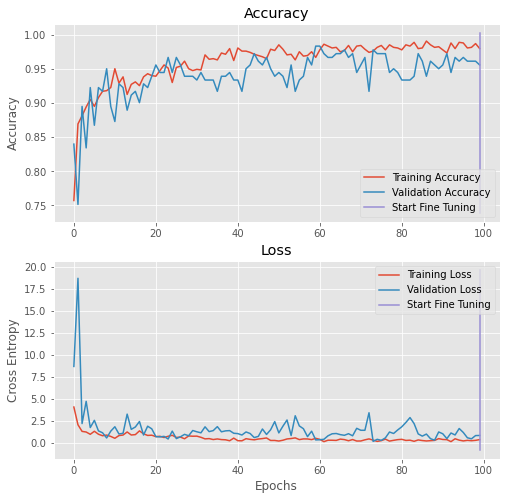

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.9358 - accuracy: 0.9297

2/5 [===========>..................] - ETA: 2s - loss: 2.8304 - accuracy: 0.9297

3/5 [=================>............] - ETA: 2s - loss: 1.9534 - accuracy: 0.9505

4/5 [=======================>......] - ETA: 1s - loss: 1.4650 - accuracy: 0.9629

5/5 [==============================] - ETA: 0s - loss: 1.4205 - accuracy: 0.9633

5/5 [==============================] - 9s 2s/step - loss: 1.4205 - accuracy: 0.9633


[1.4204739332199097, 0.963302731513977]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

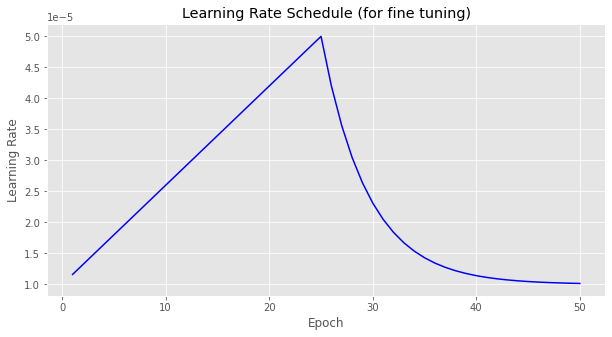

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1087 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2202 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 5s - loss: 0.1316 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 7s - loss: 0.0877 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 8s - loss: 0.0760 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.0608 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 9s - loss: 0.1008 - accuracy: 0.9870 

 7/17 [===========>..................] - ETA: 10s - loss: 0.0916 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 10s - loss: 0.2095 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 9s - loss: 0.2039 - accuracy: 0.9809 

10/17 [================>.............] - ETA: 8s - loss: 0.2968 - accuracy: 0.9750

11/17 [==================>...........] - ETA: 7s - loss: 0.2698 - accuracy: 0.9773

12/17 [====================>.........] - ETA: 6s - loss: 0.2929 - accuracy: 0.9766

13/17 [=====================>........] - ETA: 4s - loss: 0.2704 - accuracy: 0.9784

14/17 [=======================>......] - ETA: 3s - loss: 0.2570 - accuracy: 0.9788

15/17 [=========================>....] - ETA: 2s - loss: 0.2398 - accuracy: 0.9802

16/17 [===========================>..] - ETA: 1s - loss: 0.3547 - accuracy: 0.9775

17/17 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.9788

17/17 [==============================] - 21s 1s/step - loss: 0.3342 - accuracy: 0.9788 - val_loss: 0.7390 - val_accuracy: 0.9558



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 4.6969e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 4.5910e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 3.0607e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 18s - loss: 2.2955e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 16s - loss: 2.1623e-04 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 14s - loss: 0.0269 - accuracy: 0.9948    

 7/17 [===========>..................] - ETA: 16s - loss: 0.0964 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0844 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.1487 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1763 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2449 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2351 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2171 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2819 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.3106 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.3039 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.2862 - accuracy: 0.9853 - val_loss: 0.6903 - val_accuracy: 0.9613



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2552 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.5468 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.3842 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 11s - loss: 0.3560 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.3435 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 16s - loss: 0.3286 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 15s - loss: 0.2828 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 14s - loss: 0.3018 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 13s - loss: 0.2857 - accuracy: 0.9809

10/17 [================>.............] - ETA: 10s - loss: 0.2700 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2465 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.2260 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2535 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2354 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2197 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2217 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.2245 - accuracy: 0.9853 - val_loss: 0.6348 - val_accuracy: 0.9558



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.0796 - accuracy: 0.9844    

 3/17 [====>.........................] - ETA: 17s - loss: 0.1075 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.0807 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.0752 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.0627 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1613 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1570 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1557 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.1945 - accuracy: 0.9859 

11/17 [==================>...........] - ETA: 8s - loss: 0.1772 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 6s - loss: 0.2648 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2720 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 3s - loss: 0.2832 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.3218 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.3177 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.9825

17/17 [==============================] - 23s 1s/step - loss: 0.2993 - accuracy: 0.9825 - val_loss: 0.6148 - val_accuracy: 0.9558



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1718 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.2423 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 14s - loss: 0.2448 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 11s - loss: 0.1983 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 15s - loss: 0.2143 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 12s - loss: 0.2190 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 15s - loss: 0.2177 - accuracy: 0.9732

 8/17 [=============>................] - ETA: 14s - loss: 0.1905 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 13s - loss: 0.1697 - accuracy: 0.9792

10/17 [================>.............] - ETA: 10s - loss: 0.1617 - accuracy: 0.9797

11/17 [==================>...........] - ETA: 9s - loss: 0.1708 - accuracy: 0.9801 

12/17 [====================>.........] - ETA: 7s - loss: 0.1566 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.1549 - accuracy: 0.9808

14/17 [=======================>......] - ETA: 3s - loss: 0.1455 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.1358 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.1971 - accuracy: 0.9795

17/17 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9807

17/17 [==============================] - 23s 1s/step - loss: 0.1857 - accuracy: 0.9807 - val_loss: 0.5940 - val_accuracy: 0.9558



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 0.0115 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 8s - loss: 0.0489 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 7s - loss: 0.0664 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.0531 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 9s - loss: 0.2022 - accuracy: 0.9870 

 7/17 [===========>..................] - ETA: 10s - loss: 0.1864 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 10s - loss: 0.1990 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 10s - loss: 0.1877 - accuracy: 0.9844

10/17 [================>.............] - ETA: 9s - loss: 0.1862 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 8s - loss: 0.1693 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 6s - loss: 0.2164 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2169 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.2014 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2186 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2127 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9844

17/17 [==============================] - 21s 1s/step - loss: 0.2158 - accuracy: 0.9844 - val_loss: 0.5732 - val_accuracy: 0.9558



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0735 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 13s - loss: 0.2477 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 13s - loss: 0.2740 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 17s - loss: 0.2055 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.2086 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 13s - loss: 0.1738 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.1854 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 12s - loss: 0.1898 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.1687 - accuracy: 0.9844

10/17 [================>.............] - ETA: 10s - loss: 0.1518 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1455 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1333 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1231 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1143 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1067 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1000 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9908

17/17 [==============================] - 23s 1s/step - loss: 0.0943 - accuracy: 0.9908 - val_loss: 0.5572 - val_accuracy: 0.9613



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5480 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 5s - loss: 0.4088 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 10s - loss: 0.3416 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 9s - loss: 0.2562 - accuracy: 0.9805 

 5/17 [=======>......................] - ETA: 10s - loss: 0.2050 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.2063 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.2272 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 11s - loss: 0.2170 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 10s - loss: 0.1929 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.1740 - accuracy: 0.9875 

11/17 [==================>...........] - ETA: 7s - loss: 0.1652 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 6s - loss: 0.1612 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 4s - loss: 0.1492 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1387 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1639 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.1795 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.9862

17/17 [==============================] - 21s 1s/step - loss: 0.1691 - accuracy: 0.9862 - val_loss: 0.5611 - val_accuracy: 0.9613



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0185 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0274 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 18s - loss: 0.0182 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.0137 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 11s - loss: 0.0340 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.0243 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.0191 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.0356 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.0554 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.0508 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0858 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.0796 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.0949 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1064 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9871

17/17 [==============================] - 22s 1s/step - loss: 0.1271 - accuracy: 0.9871 - val_loss: 0.5516 - val_accuracy: 0.9613



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 1.3659e-08 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 21s - loss: 0.0633 - accuracy: 0.9922    

 5/17 [=======>......................] - ETA: 20s - loss: 0.1752 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 16s - loss: 0.1461 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1548 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1356 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1743 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.1860 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 8s - loss: 0.1691 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.1550 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1431 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1628 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1519 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1544 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1455 - accuracy: 0.9890 - val_loss: 0.5509 - val_accuracy: 0.9724



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 1.0795 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 8s - loss: 0.6666 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 14s - loss: 0.4444 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 11s - loss: 0.4466 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.3807 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.3173 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 12s - loss: 0.2720 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.2792 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.2482 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.2234 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.2220 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2035 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1949 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.2656 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2594 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2432 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.2302 - accuracy: 0.9880 - val_loss: 0.5526 - val_accuracy: 0.9779



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.2598 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 23s - loss: 0.2888 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 18s - loss: 0.2166 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.2343 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 18s - loss: 0.1953 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1674 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.2206 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1960 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1764 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.2090 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1916 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1769 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1687 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1574 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1886 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.1870 - accuracy: 0.9908 - val_loss: 0.5523 - val_accuracy: 0.9779



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0667 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.0334 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 23s - loss: 0.0222 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 18s - loss: 0.1035 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.2510 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.2092 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.2166 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.3071 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.2736 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2809 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2807 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2627 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2425 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2252 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2596 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2434 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.2293 - accuracy: 0.9871 - val_loss: 0.5610 - val_accuracy: 0.9779



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2273 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.2209 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 15s - loss: 0.2779 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 14s - loss: 0.2155 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 17s - loss: 0.2032 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.1693 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.1451 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 16s - loss: 0.1270 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 14s - loss: 0.1649 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1484 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1349 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1242 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1147 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1107 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1208 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1132 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9917

17/17 [==============================] - 24s 1s/step - loss: 0.1066 - accuracy: 0.9917 - val_loss: 0.5713 - val_accuracy: 0.9779



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 2.0484e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.1974 - accuracy: 0.9844    

 3/17 [====>.........................] - ETA: 16s - loss: 0.1316 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.0987 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.0790 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0659 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 16s - loss: 0.0566 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 15s - loss: 0.0496 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 13s - loss: 0.1117 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1006 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0916 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0870 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1460 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1356 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1266 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1540 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9899

17/17 [==============================] - 23s 1s/step - loss: 0.1539 - accuracy: 0.9899 - val_loss: 0.5802 - val_accuracy: 0.9779



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 0.1028 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 15s - loss: 0.0832 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0624 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.0499 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.0416 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0357 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0841 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0780 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0702 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1003 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.0920 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1001 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.0942 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1312 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1230 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.1159 - accuracy: 0.9890 - val_loss: 0.5859 - val_accuracy: 0.9779



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4542 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 6s - loss: 0.2658 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 14s - loss: 0.1772 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 11s - loss: 0.1414 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.1131 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.0942 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.0809 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.0708 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.0629 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1895 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1737 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1600 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1557 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.1446 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1464 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1373 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1293 - accuracy: 0.9890 - val_loss: 0.5892 - val_accuracy: 0.9779



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 5.5879e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 4.6566e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 4.9671e-09 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 0.0516 - accuracy: 0.9922    

 5/17 [=======>......................] - ETA: 16s - loss: 0.0694 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0946 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 15s - loss: 0.1307 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.1144 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 11s - loss: 0.1733 - accuracy: 0.9826

10/17 [================>.............] - ETA: 9s - loss: 0.1565 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 7s - loss: 0.1511 - accuracy: 0.9844

12/17 [====================>.........] - ETA: 6s - loss: 0.1385 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2342 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 3s - loss: 0.2175 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2030 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.1903 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9871

17/17 [==============================] - 23s 1s/step - loss: 0.1793 - accuracy: 0.9871 - val_loss: 0.5959 - val_accuracy: 0.9779



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1304 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.2626 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 4s - loss: 0.1751 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 5s - loss: 0.1313 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 8s - loss: 0.1051 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 9s - loss: 0.0875 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.0750 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.0858 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.0767 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.0890 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.1183 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1153 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1350 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1281 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1365 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1283 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9853

17/17 [==============================] - 21s 1s/step - loss: 0.2227 - accuracy: 0.9853 - val_loss: 0.5951 - val_accuracy: 0.9779



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.3419 - accuracy: 0.9688   

 3/17 [====>.........................] - ETA: 9s - loss: 0.2280 - accuracy: 0.9792 

 4/17 [======>.......................] - ETA: 10s - loss: 0.1736 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.1389 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 12s - loss: 0.1157 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.2536 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 12s - loss: 0.2219 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.2253 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.2304 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2598 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2616 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2415 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.2367 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2230 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2199 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.2318 - accuracy: 0.9853 - val_loss: 0.5955 - val_accuracy: 0.9779



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 0.1024 - accuracy: 0.9844    

 3/17 [====>.........................] - ETA: 10s - loss: 0.0682 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 10s - loss: 0.3111 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 10s - loss: 0.2489 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.2904 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.2489 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.2655 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.2452 - accuracy: 0.9826

10/17 [================>.............] - ETA: 10s - loss: 0.2207 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.2006 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 6s - loss: 0.1839 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1698 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.2075 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2173 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2621 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9834

17/17 [==============================] - 22s 1s/step - loss: 0.2469 - accuracy: 0.9834 - val_loss: 0.6021 - val_accuracy: 0.9779



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2944 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 6s - loss: 0.1655 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 8s - loss: 0.1103 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 10s - loss: 0.0830 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.0664 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 12s - loss: 0.0553 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 11s - loss: 0.0474 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 11s - loss: 0.0415 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 10s - loss: 0.0369 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.0332 - accuracy: 0.9953 

11/17 [==================>...........] - ETA: 8s - loss: 0.0311 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 6s - loss: 0.0285 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0264 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 3s - loss: 0.0269 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0251 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0521 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9917

17/17 [==============================] - 22s 1s/step - loss: 0.1284 - accuracy: 0.9917 - val_loss: 0.6027 - val_accuracy: 0.9779



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 2.5293e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 1.2646e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 1.0964e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 19s - loss: 0.1873 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 17s - loss: 0.1498 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.2707 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.3474 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.3039 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.2702 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2694 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2452 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2949 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2777 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2670 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2520 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2661 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9825

17/17 [==============================] - 24s 1s/step - loss: 0.2752 - accuracy: 0.9825 - val_loss: 0.6055 - val_accuracy: 0.9779



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 4.0633e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 2.0316e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 0.0811 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 10s - loss: 0.0828 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 12s - loss: 0.0685 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 12s - loss: 0.1878 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.1610 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 11s - loss: 0.1409 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 10s - loss: 0.1372 - accuracy: 0.9878

10/17 [================>.............] - ETA: 8s - loss: 0.1235 - accuracy: 0.9891 

11/17 [==================>...........] - ETA: 7s - loss: 0.1123 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1392 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1285 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1193 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1129 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1183 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9890

17/17 [==============================] - 21s 1s/step - loss: 0.1114 - accuracy: 0.9890 - val_loss: 0.5996 - val_accuracy: 0.9779



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 0.6809 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 5s - loss: 0.3750 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 5s - loss: 0.2500 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 17s - loss: 0.1875 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 13s - loss: 0.1783 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 11s - loss: 0.1486 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 11s - loss: 0.1274 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 11s - loss: 0.1115 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.0991 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.0892 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 7s - loss: 0.0811 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0743 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0686 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0849 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0793 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0814 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9917

17/17 [==============================] - 22s 1s/step - loss: 0.0802 - accuracy: 0.9917 - val_loss: 0.5980 - val_accuracy: 0.9779



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2370 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 9s - loss: 0.1361 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 22s - loss: 0.1047 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 19s - loss: 0.0824 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 15s - loss: 0.0673 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.0635 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 13s - loss: 0.0575 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.0533 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.0473 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.0644 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.0678 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.0623 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.0575 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.0534 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.0499 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.0468 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.0440 - accuracy: 0.9899 - val_loss: 0.5988 - val_accuracy: 0.9779



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7697 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 8s - loss: 0.3848 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 15s - loss: 0.2766 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 12s - loss: 0.2074 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.2418 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.2015 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.2290 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 12s - loss: 0.2300 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 11s - loss: 0.2045 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.1840 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1673 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1534 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1691 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1570 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1467 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.2603 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9899

17/17 [==============================] - 23s 1s/step - loss: 0.2452 - accuracy: 0.9899 - val_loss: 0.6040 - val_accuracy: 0.9779



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 7.6961e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 9s - loss: 0.0286 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 16s - loss: 0.0214 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.0172 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 14s - loss: 0.0143 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 12s - loss: 0.0415 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0672 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.1006 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1135 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1275 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1180 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1096 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1023 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0959 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9899

17/17 [==============================] - 23s 1s/step - loss: 0.1041 - accuracy: 0.9899 - val_loss: 0.6126 - val_accuracy: 0.9779



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.3796 - accuracy: 0.9844    

 3/17 [====>.........................] - ETA: 19s - loss: 0.4036 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.3065 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.2452 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.2522 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.2477 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.2780 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2502 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 8s - loss: 0.2799 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2565 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2373 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.2422 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2381 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2232 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.2103 - accuracy: 0.9880 - val_loss: 0.6282 - val_accuracy: 0.9779



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3258 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 13s - loss: 0.1629 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.2052 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 13s - loss: 0.1539 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.1232 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1027 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.0924 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.0808 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.0718 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1149 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.1149 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.1220 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.1126 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.1046 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.0976 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1144 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.1078 - accuracy: 0.9871 - val_loss: 0.6255 - val_accuracy: 0.9779



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 1.3039e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 7.4183e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 7s - loss: 0.0826 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 9s - loss: 0.0620 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.1055 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 18s - loss: 0.1476 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1266 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.1107 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0984 - accuracy: 0.9948

10/17 [================>.............] - ETA: 10s - loss: 0.0886 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 8s - loss: 0.0852 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 6s - loss: 0.0781 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0721 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 3s - loss: 0.0865 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.1185 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1201 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.9936

17/17 [==============================] - 22s 1s/step - loss: 0.1131 - accuracy: 0.9936 - val_loss: 0.6262 - val_accuracy: 0.9779



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0248 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.0124 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 19s - loss: 0.1466 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.1498 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.2212 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 18s - loss: 0.1864 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 17s - loss: 0.2046 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 15s - loss: 0.1790 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.1680 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.1512 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.1375 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.1492 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1377 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1279 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1225 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1223 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.1311 - accuracy: 0.9862 - val_loss: 0.6308 - val_accuracy: 0.9779



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 1.1176e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.2330 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 20s - loss: 0.1750 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.4053 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 17s - loss: 0.3242 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.2702 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.2784 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.3589 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.3333 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2999 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 8s - loss: 0.2727 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2499 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2398 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.2226 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2132 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1999 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.1972 - accuracy: 0.9890 - val_loss: 0.6319 - val_accuracy: 0.9779



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 6.5193e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 15s - loss: 4.3462e-09 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 15s - loss: 1.5531e-06 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 15s - loss: 0.0373 - accuracy: 0.9937    

 6/17 [=========>....................] - ETA: 14s - loss: 0.1144 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.0981 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0858 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0836 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.0753 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 8s - loss: 0.0695 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0637 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0613 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.0570 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1197 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1122 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1136 - accuracy: 0.9890 - val_loss: 0.6292 - val_accuracy: 0.9779



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4337 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 11s - loss: 0.3614 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 16s - loss: 0.3381 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 14s - loss: 0.2536 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 17s - loss: 0.2029 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.2116 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 16s - loss: 0.1814 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.1587 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.2454 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2762 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2653 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2456 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2284 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2166 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2032 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.1914 - accuracy: 0.9890 - val_loss: 0.6305 - val_accuracy: 0.9779



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 17s - loss: 0.2486 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 18s - loss: 0.1657 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.1479 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.1183 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.0986 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1016 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1041 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.0925 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.0835 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1511 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1604 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1480 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1463 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1475 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1448 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.1788 - accuracy: 0.9853 - val_loss: 0.6296 - val_accuracy: 0.9779



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0388 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 5s - loss: 0.5573 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 13s - loss: 0.4951 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 17s - loss: 0.3713 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 15s - loss: 0.2971 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.2520 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 12s - loss: 0.2160 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 12s - loss: 0.1892 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 10s - loss: 0.1926 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.2279 - accuracy: 0.9859 

11/17 [==================>...........] - ETA: 8s - loss: 0.2072 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 7s - loss: 0.1899 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1827 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1729 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1866 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2140 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9871

17/17 [==============================] - 22s 1s/step - loss: 0.2016 - accuracy: 0.9871 - val_loss: 0.6410 - val_accuracy: 0.9724



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 4.2841e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 1.9435e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 1.3058e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 0.0585 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 16s - loss: 0.1034 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.0983 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.1570 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1681 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1583 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1710 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.1708 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1567 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1447 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1834 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1776 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1724 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.1625 - accuracy: 0.9880 - val_loss: 0.6486 - val_accuracy: 0.9724



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0268 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0134 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0090 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.0068 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.0054 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.0446 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.0645 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.0914 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.1005 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.0963 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.0876 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1067 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.0985 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1104 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1632 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9862

17/17 [==============================] - 23s 1s/step - loss: 0.1537 - accuracy: 0.9862 - val_loss: 0.6439 - val_accuracy: 0.9724



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 5.8364e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 3.2069e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 2.1802e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 19s - loss: 2.8425e-06 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 17s - loss: 0.1529 - accuracy: 0.9937    

 6/17 [=========>....................] - ETA: 14s - loss: 0.1275 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.1093 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 15s - loss: 0.0958 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 13s - loss: 0.0851 - accuracy: 0.9965

10/17 [================>.............] - ETA: 11s - loss: 0.0903 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.0821 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0999 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0924 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0858 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0801 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0751 - accuracy: 0.9961

17/17 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9963

17/17 [==============================] - 24s 1s/step - loss: 0.0708 - accuracy: 0.9963 - val_loss: 0.6621 - val_accuracy: 0.9724



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4139 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 17s - loss: 0.2391 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 19s - loss: 0.1594 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.1303 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.1042 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.0869 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.0745 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.0731 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1094 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1250 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1136 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1042 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1073 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.0996 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0930 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.0821 - accuracy: 0.9926 - val_loss: 0.6537 - val_accuracy: 0.9724



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3465 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 17s - loss: 0.2505 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 21s - loss: 0.2671 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 20s - loss: 0.2004 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.1603 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.1337 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1146 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.1447 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1286 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1158 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1088 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1002 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0925 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.0863 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0805 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0866 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9945

17/17 [==============================] - 24s 1s/step - loss: 0.0816 - accuracy: 0.9945 - val_loss: 0.6522 - val_accuracy: 0.9724



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 2.5989e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 23s - loss: 0.0612 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0408 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.1116 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.1181 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.0998 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 15s - loss: 0.0866 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.0980 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.0871 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.0784 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.0713 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0654 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0853 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.0878 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1409 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1438 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.1354 - accuracy: 0.9880 - val_loss: 0.6412 - val_accuracy: 0.9724



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 15s - loss: 0.1689 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 12s - loss: 0.1127 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.0845 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 15s - loss: 0.0676 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 14s - loss: 0.1549 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.1328 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.1415 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.1310 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1179 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1072 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0983 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0907 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 3s - loss: 0.0842 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0793 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0842 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9926

17/17 [==============================] - 23s 1s/step - loss: 0.1271 - accuracy: 0.9926 - val_loss: 0.6329 - val_accuracy: 0.9724



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 2.2910e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 1.1548e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 0.0223 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 12s - loss: 0.0127 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 15s - loss: 0.1146 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.2044 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1956 - accuracy: 0.9896

10/17 [================>.............] - ETA: 9s - loss: 0.1764 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 8s - loss: 0.1604 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.1470 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1483 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1574 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1474 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1499 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9899

17/17 [==============================] - 22s 1s/step - loss: 0.1821 - accuracy: 0.9899 - val_loss: 0.6254 - val_accuracy: 0.9724



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3729 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.1865 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 19s - loss: 0.1243 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.0932 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.1144 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.1272 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1090 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0954 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1115 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1003 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 8s - loss: 0.0912 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 6s - loss: 0.0944 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0872 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0809 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0756 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0709 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9954

17/17 [==============================] - 23s 1s/step - loss: 0.0667 - accuracy: 0.9954 - val_loss: 0.6137 - val_accuracy: 0.9724



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 3.9360e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 22s - loss: 0.1386 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0924 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.0693 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 15s - loss: 0.0555 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 17s - loss: 0.0868 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.1850 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 14s - loss: 0.1619 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.1570 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1574 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1432 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1312 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1372 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1368 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1277 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1702 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9862

17/17 [==============================] - 23s 1s/step - loss: 0.1604 - accuracy: 0.9862 - val_loss: 0.6085 - val_accuracy: 0.9724



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 5.2154e-08 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 9s - loss: 0.0809 - accuracy: 0.9948     

 4/17 [======>.......................] - ETA: 12s - loss: 0.1146 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.0919 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 11s - loss: 0.1492 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.1279 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1119 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.1024 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.0922 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 8s - loss: 0.0838 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0878 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0816 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.0757 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0707 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0795 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9917

17/17 [==============================] - 22s 1s/step - loss: 0.0921 - accuracy: 0.9917 - val_loss: 0.6195 - val_accuracy: 0.9724



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1893 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.0947 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 7s - loss: 0.0632 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.0724 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.2485 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 12s - loss: 0.2076 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 12s - loss: 0.1780 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 11s - loss: 0.1756 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 11s - loss: 0.1561 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.2102 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.1911 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 6s - loss: 0.1752 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1617 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1502 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1402 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1314 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9908

17/17 [==============================] - 22s 1s/step - loss: 0.1239 - accuracy: 0.9908 - val_loss: 0.6165 - val_accuracy: 0.9724



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 0.9637 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 0.7244 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 11s - loss: 0.5340 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 9s - loss: 0.4005 - accuracy: 0.9805 

 5/17 [=======>......................] - ETA: 11s - loss: 0.3314 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.2762 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 12s - loss: 0.2368 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 12s - loss: 0.2072 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 10s - loss: 0.2085 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.1878 - accuracy: 0.9891 

11/17 [==================>...........] - ETA: 7s - loss: 0.1707 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1565 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1558 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.2138 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1995 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.2148 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9871

17/17 [==============================] - 22s 1s/step - loss: 0.2023 - accuracy: 0.9871 - val_loss: 0.6170 - val_accuracy: 0.9724


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

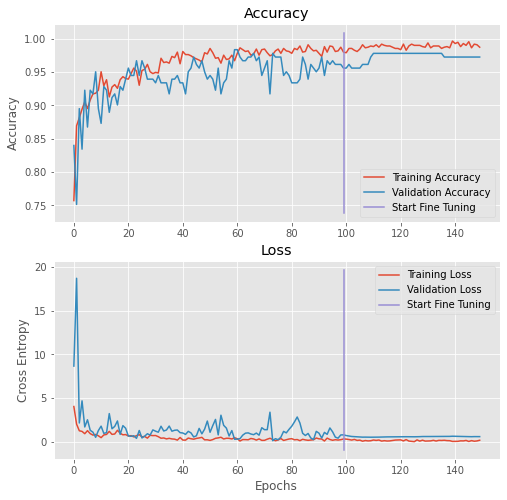

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.3898 - accuracy: 0.9453

2/5 [===========>..................] - ETA: 2s - loss: 2.4603 - accuracy: 0.9492

3/5 [=================>............] - ETA: 2s - loss: 1.7386 - accuracy: 0.9635

4/5 [=======================>......] - ETA: 1s - loss: 1.3040 - accuracy: 0.9727

5/5 [==============================] - ETA: 0s - loss: 1.2571 - accuracy: 0.9725

5/5 [==============================] - 6s 1s/step - loss: 1.2571 - accuracy: 0.9725


[1.2570501565933228, 0.9724770784378052]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9724770642201835
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       158
           1       0.97      0.99      0.98       387

    accuracy                           0.97       545
   macro avg       0.97      0.96      0.97       545
weighted avg       0.97      0.97      0.97       545



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

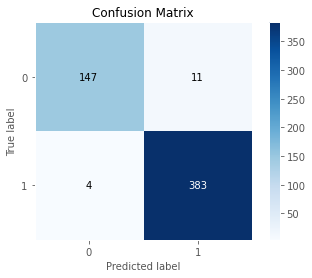

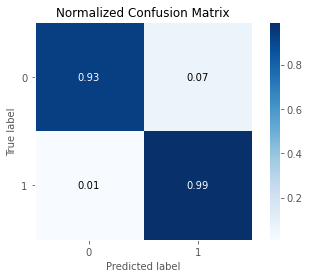

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

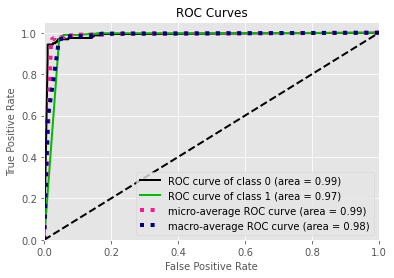

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       158
           1       0.97      0.99      0.98       387

    accuracy                           0.97       545
   macro avg       0.97      0.96      0.97       545
weighted avg       0.97      0.97      0.97       545

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.93      0.99      0.95      0.96      0.92       158
          1       0.97      0.99      0.93      0.98      0.96      0.93       387

avg / total       0.97      0.97      0.95      0.97      0.96      0.92       545

